In [1]:
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import pathlib
import csv

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler

from keras.regularizers import l2
import keras
from keras import layers
import keras
from keras.models import Sequential
from scipy import stats

In [8]:
!mv '~/Google\ Drive\ File\ Stream/Мой\ диск/training_data.tar.gz' './training_data.tar.gz'
!mv '~/Google\ Drive\ File\ Stream/Мой\ диск/Testing_Data_MLTASK.tar.gz' './testing_data.tar.gz'
!tar xvzf training_data.tar.gz
!tar xvzf testing_data.tar.gz

mv: ~/Google\ Drive\ File\ Stream/Мой\ диск/training_data.tar.gz: No such file or directory


In [15]:
def conversion_from_wav_to_csv(path, f = False):
    #Заголовки для csv
    header = 'filename chroma_stft chroma_cqt chroma_cens melspectrogram rmse spectral_centroid spectral_bandwidth spectral_contrast spectral_flatness rolloff poly_features tonnetz zero_crossing_rate'
    for i in range(1, 21):
        header += f' mfcc{i}'
    header += ' label'
    header = header.split()
    
    if f:
        del header[-1]
        file = open('test.csv', 'w', newline='')
    else:
        file = open('testdataset.csv', 'w', newline='')
    
    with file:
        writer = csv.writer(file)
        writer.writerow(header)
    classes = 'human spoof'.split()
    test = ['Testing_Data']
    if f:
        classes = test
    for c in classes:
        for filename in sorted(os.listdir(f'{path}/{c}')):
            soundname = f'{path}/{c}/{filename}'
            y, sr = librosa.load(soundname, mono=True, duration=30)
            rms = librosa.feature.rms(y=y)
            chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
            chroma_cqt = librosa.feature.chroma_cqt(y=y, sr=sr)
            chroma_cens = librosa.feature.chroma_cens(y=y, sr=sr)
            melspectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
            spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
            spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
            spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
            spectral_flatness = librosa.feature.spectral_flatness(y=y)
            poly_features = librosa.feature.poly_features(y=y, sr=sr)
            rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
            tonnetz = librosa.feature.tonnetz(y=y, sr=sr)
            zcr = librosa.feature.zero_crossing_rate(y=y)
            mfcc = librosa.feature.mfcc(y=y, sr=sr)
            to_append = f'{filename} {np.mean(chroma_stft)} {np.mean(chroma_cqt)} {np.mean(chroma_cens)} {np.mean(melspectrogram)} {np.mean(rms)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(spectral_contrast)} {np.mean(spectral_flatness)} {np.mean(rolloff)} {np.mean(poly_features)} {np.mean(tonnetz)} {np.mean(zcr)}'    
            for e in mfcc:
                to_append += f' {np.mean(e)}'
            if f == False:
                to_append += f' {c}'
                file = open('new-dataset.csv', 'a', newline='')
            else:
                file = open('test.csv', 'a', newline='')
            with file:
                writer = csv.writer(file)
                writer.writerow(to_append.split())

In [ ]:
conversion_from_wav_to_csv('./Training_Data', f=False)

/Users/inter000/opt/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=920
  warnings.warn(
/Users/inter000/opt/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=889
  warnings.warn(
/Users/inter000/opt/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=962
  warnings.warn(
/Users/inter000/opt/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=910
  warnings.warn(
/Users/inter000/opt/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=982
  warnings.warn(
/Users/inter000/opt/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=1024 is too small for input 

In [2]:
data = pd.read_csv('new-dataset.csv')
#data = data.sample(frac=1).reset_index(drop=True)
data.head()

,filename,chroma_stft,chroma_cqt,chroma_cens,melspectrogram,rmse,spectral_centroid,spectral_bandwidth,spectral_contrast,spectral_flatness,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,human_00000.wav,0.353022,0.379043,0.226496,0.762776,0.042762,1698.311629,1708.273546,23.678257,0.000460,...,-4.520185,-4.032321,-8.738158,-4.378027,-13.430143,4.926398,-7.972149,-5.450690,-2.770082,human
1,human_00001.wav,0.479716,0.505701,0.263431,0.003375,0.003636,1553.135885,1514.208772,23.477752,0.000298,...,8.148829,11.660575,-4.594286,14.093516,-1.010832,7.608933,2.417472,12.535056,2.939179,human
2,human_00002.wav,0.345533,0.386483,0.232112,1.288489,0.059232,1458.539398,1590.756452,23.376160,0.000246,...,-0.932909,-4.581821,1.384029,1.174273,-5.940725,2.146938,-7.342173,-3.320397,-2.511549,human
3,human_00003.wav,0.312623,0.345350,0.225629,0.005430,0.004049,2377.953299,1805.998107,25.065315,0.004103,...,-12.554141,-3.270665,-10.091649,2.089070,-10.832205,-0.316745,-10.121890,-2.006853,-9.425464,human
4,human_00004.wav,0.397256,0.484098,0.267282,0.092597,0.014278,1932.324862,1383.286507,24.455445,0.002782,...,-4.455951,-0.867689,-8.473683,4.679375,-8.171278,-0.674227,-3.593829,-2.961659,-3.126526,human


In [183]:
len(data1)
#len(data2)

9481

In [3]:
# Удаление ненужных столбцов
duplicates = []
with open('w_file_file.txt') as f:
    for line in f:
        duplicates.append(line.split()[0][6:])
data = data[[all([x not in duplicates for x in i]) for i in data['filename']]]
#data = data.drop(['spectral_centroid', 'rolloff', 'mfcc2', 'mfcc4', 'mfcc13', 'mfcc3', 'mfcc5', 'mfcc8'],axis=1)
#data = data.drop(['filename'],axis=1)
print(len(data))
data1 = data.iloc[:10322]
data2 = data.iloc[10322:]
#print(len(list(filter(lambda x: 'human' in x, data2['filename']))))
data1 = data1[(np.abs(stats.zscore(data1.iloc[:, 1:-1])) < 3).all(axis=1)]
data2 = data2[(np.abs(stats.zscore(data2.iloc[:, 1:-1])) < 3).all(axis=1)]
data = pd.concat([data1, data2], axis=0)
print(len(data))
# Создание меток
data = data.sample(frac=1).reset_index(drop=True)
d = {'human': 1, 'spoof': 0}
data = data.replace(d)
y = data.iloc[:, [0, -1]]
# Нормализация столбцов признаков
scaler = StandardScaler()
X = scaler.fit_transform(np.array(data.iloc[:, 1:-1], dtype = float))
# Разделение данных на обучающий и тестовый наборd
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
data.head()

50000
41424


,filename,chroma_stft,chroma_cqt,chroma_cens,melspectrogram,rmse,spectral_centroid,spectral_bandwidth,spectral_contrast,spectral_flatness,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,spoof_15975.wav,0.351635,0.390244,0.247826,2.011333,0.080356,1518.455642,1419.600828,24.616037,0.000192,...,-7.537591,5.177295,-10.420002,5.435840,-9.285482,0.764476,-5.334121,-2.448223,-0.304945,0
1,spoof_24043.wav,0.425282,0.445616,0.259039,2.086291,0.073859,1813.565342,1562.665177,24.042686,0.000467,...,-4.850761,-5.438842,-9.442325,6.444769,-5.392128,3.737611,-4.666868,1.627533,-1.978563,0
2,human_03008.wav,0.482074,0.571549,0.276126,1.465196,0.056376,1518.304205,1488.368605,21.989166,0.000306,...,1.304520,1.221297,-7.726157,5.790867,5.363612,-11.184999,2.468588,-1.166933,0.598850,1
3,spoof_28671.wav,0.317620,0.485554,0.257021,0.268827,0.027373,2274.533278,1858.708529,24.057292,0.000534,...,-19.151142,7.099208,-16.067028,0.526547,-18.147263,2.347704,-2.975345,-10.918173,0.806392,0
4,human_00922.wav,0.397364,0.520293,0.277598,0.289141,0.030672,1977.556023,2040.120794,24.162294,0.000395,...,-4.239605,0.148214,-5.144867,9.533783,-10.879691,12.597129,-12.406382,10.780697,-3.178561,1


In [16]:
d = pd.DataFrame(X)
d.corr()

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,1.000000,0.718136,0.591841,-0.458686,-0.484914,0.147163,0.322583,-0.442546,-0.341925,0.227077,...,0.138100,0.239643,0.318593,-0.068207,0.360240,0.244814,0.179921,0.103227,0.405300,0.028861
1,0.718136,1.000000,0.897708,-0.398207,-0.479606,0.158176,0.242029,-0.643054,-0.202775,0.191008,...,0.131002,0.109182,0.160163,0.004510,0.245711,0.133124,0.196914,0.095999,0.251383,0.119106
2,0.591841,0.897708,1.000000,-0.370689,-0.436089,0.180550,0.178758,-0.551669,-0.156172,0.187509,...,0.114688,0.097089,0.107856,0.044616,0.251314,0.124589,0.220031,0.121258,0.263810,0.157839
3,-0.458686,-0.398207,-0.370689,1.000000,0.953072,-0.229549,-0.355486,0.032946,0.582523,-0.294255,...,0.005405,-0.220916,-0.090685,-0.041054,-0.264857,-0.117676,-0.247906,-0.124174,-0.289665,-0.098397
4,-0.484914,-0.479606,-0.436089,0.953072,1.000000,-0.178741,-0.347162,0.121213,0.542353,-0.247429,...,-0.016936,-0.226395,-0.104187,-0.093234,-0.269240,-0.141688,-0.275869,-0.140460,-0.285476,-0.149619
5,0.147163,0.158176,0.180550,-0.229549,-0.178741,1.000000,0.631720,0.182427,-0.132828,0.927251,...,-0.051030,-0.040932,-0.037445,-0.220995,0.180172,-0.293438,0.169999,-0.176105,0.124121,-0.161687
6,0.322583,0.242029,0.178758,-0.355486,-0.347162,0.631720,1.000000,0.054815,-0.290944,0.836642,...,0.082193,0.020011,0.094210,-0.220801,0.274110,-0.277463,0.262700,-0.208020,0.156373,-0.060078
7,-0.442546,-0.643054,-0.551669,0.032946,0.121213,0.182427,0.054815,1.000000,-0.157495,0.155963,...,-0.204033,0.001398,-0.027100,-0.103703,0.045466,-0.123341,-0.006434,-0.105491,0.049310,-0.175405
8,-0.341925,-0.202775,-0.156172,0.582523,0.542353,-0.132828,-0.290944,-0.157495,1.000000,-0.191323,...,-0.007217,-0.138720,0.016910,-0.055887,-0.113501,-0.061273,-0.120319,-0.047242,-0.148366,-0.042329
9,0.227077,0.191008,0.187509,-0.294255,-0.247429,0.927251,0.836642,0.155963,-0.191323,1.000000,...,0.008927,-0.007982,0.002516,-0.225062,0.227524,-0.285881,0.206756,-0.200066,0.165328,-0.137323


In [17]:
data.corr()

,chroma_stft,chroma_cqt,chroma_cens,melspectrogram,rmse,spectral_centroid,spectral_bandwidth,spectral_contrast,spectral_flatness,rolloff,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
chroma_stft,1.000000,0.718136,0.591841,-0.458686,-0.484914,0.147163,0.322583,-0.442546,-0.341925,0.227077,...,0.239643,0.318593,-0.068207,0.360240,0.244814,0.179921,0.103227,0.405300,0.028861,0.123432
chroma_cqt,0.718136,1.000000,0.897708,-0.398207,-0.479606,0.158176,0.242029,-0.643054,-0.202775,0.191008,...,0.109182,0.160163,0.004510,0.245711,0.133124,0.196914,0.095999,0.251383,0.119106,-0.063013
chroma_cens,0.591841,0.897708,1.000000,-0.370689,-0.436089,0.180550,0.178758,-0.551669,-0.156172,0.187509,...,0.097089,0.107856,0.044616,0.251314,0.124589,0.220031,0.121258,0.263810,0.157839,-0.012569
melspectrogram,-0.458686,-0.398207,-0.370689,1.000000,0.953072,-0.229549,-0.355486,0.032946,0.582523,-0.294255,...,-0.220916,-0.090685,-0.041054,-0.264857,-0.117676,-0.247906,-0.124174,-0.289665,-0.098397,-0.256358
rmse,-0.484914,-0.479606,-0.436089,0.953072,1.000000,-0.178741,-0.347162,0.121213,0.542353,-0.247429,...,-0.226395,-0.104187,-0.093234,-0.269240,-0.141688,-0.275869,-0.140460,-0.285476,-0.149619,-0.315971
spectral_centroid,0.147163,0.158176,0.180550,-0.229549,-0.178741,1.000000,0.631720,0.182427,-0.132828,0.927251,...,-0.040932,-0.037445,-0.220995,0.180172,-0.293438,0.169999,-0.176105,0.124121,-0.161687,-0.081660
spectral_bandwidth,0.322583,0.242029,0.178758,-0.355486,-0.347162,0.631720,1.000000,0.054815,-0.290944,0.836642,...,0.020011,0.094210,-0.220801,0.274110,-0.277463,0.262700,-0.208020,0.156373,-0.060078,0.133428
spectral_contrast,-0.442546,-0.643054,-0.551669,0.032946,0.121213,0.182427,0.054815,1.000000,-0.157495,0.155963,...,0.001398,-0.027100,-0.103703,0.045466,-0.123341,-0.006434,-0.105491,0.049310,-0.175405,0.121932
spectral_flatness,-0.341925,-0.202775,-0.156172,0.582523,0.542353,-0.132828,-0.290944,-0.157495,1.000000,-0.191323,...,-0.138720,0.016910,-0.055887,-0.113501,-0.061273,-0.120319,-0.047242,-0.148366,-0.042329,-0.199859
rolloff,0.227077,0.191008,0.187509,-0.294255,-0.247429,0.927251,0.836642,0.155963,-0.191323,1.000000,...,-0.007982,0.002516,-0.225062,0.227524,-0.285881,0.206756,-0.200066,0.165328,-0.137323,0.006001


In [204]:
print(y)
coef = 1e-3
model = Sequential()
model.add(layers.Dense(256, activation='relu', input_shape=(X.shape[1],), kernel_regularizer=l2(coef), activity_regularizer=l2(coef)))
model.add(layers.Dense(128, activation='relu', bias_regularizer=l2(coef), kernel_regularizer=l2(coef), activity_regularizer=l2(coef)))
model.add(layers.Dense(64, activation='relu', bias_regularizer=l2(coef), kernel_regularizer=l2(coef), activity_regularizer=l2(coef)))
model.add(layers.Dense(32, activation='relu', bias_regularizer=l2(coef), kernel_regularizer=l2(coef), activity_regularizer=l2(coef)))
model.add(layers.Dense(16, activation='relu', bias_regularizer=l2(coef), kernel_regularizer=l2(coef), activity_regularizer=l2(coef)))
model.add(layers.Dense(1, activation='sigmoid', bias_regularizer=l2(coef), kernel_regularizer=l2(coef), activity_regularizer=l2(coef)))
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) #sparse_categorical_crossentropy
# model.add(layers.Dense(26, input_dim=26, kernel_initializer='normal', activation='relu'))
# model.add(layers.Dense(20, kernel_initializer='normal', activation='relu'))
# model.add(layers.Dense(14, kernel_initializer='normal', activation='relu'))
# model.add(layers.Dense(8, kernel_initializer='normal', activation='relu'))
# model.add(layers.Dense(4, kernel_initializer='normal', activation='relu'))
# model.add(layers.Dense(2, kernel_initializer='normal', activation='relu'))
# model.add(layers.Dense(1, kernel_initializer='normal', activation='sigmoid'))
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


              filename  label
0      spoof_21611.wav      0
1      spoof_13910.wav      0
2      spoof_11638.wav      0
3      human_04309.wav      1
4      spoof_18711.wav      0
...                ...    ...
45973  spoof_38872.wav      0
45974  spoof_29280.wav      0
45975  human_03066.wav      1
45976  spoof_07332.wav      0
45977  spoof_13248.wav      0

[45978 rows x 2 columns]


In [205]:
classifier = model.fit(X_train, y_train['label'], epochs=100, callbacks=[callback])

Epoch 1/100
1294/1294 [==============================] - 2s 1ms/step - loss: 0.3628 - accuracy: 0.9128
Epoch 2/100
1294/1294 [==============================] - 2s 2ms/step - loss: 0.2380 - accuracy: 0.9403
Epoch 3/100
1294/1294 [==============================] - 2s 1ms/step - loss: 0.2130 - accuracy: 0.9473
Epoch 4/100
1294/1294 [==============================] - 2s 1ms/step - loss: 0.2006 - accuracy: 0.9512
Epoch 5/100
1294/1294 [==============================] - 2s 1ms/step - loss: 0.1923 - accuracy: 0.9558
Epoch 6/100
1294/1294 [==============================] - 2s 1ms/step - loss: 0.1871 - accuracy: 0.9568
Epoch 7/100
1294/1294 [==============================] - 2s 2ms/step - loss: 0.1829 - accuracy: 0.9591
Epoch 8/100
1294/1294 [==============================] - 2s 2ms/step - loss: 0.1801 - accuracy: 0.9601
Epoch 9/100
1294/1294 [==============================] - 2s 1ms/step - loss: 0.1771 - accuracy: 0.9627
Epoch 10/100
1294/1294 [==============================] - 2s 2ms/step - l

In [206]:
print(model.evaluate(X_test, y_test['label']))

144/144 [==============================] - 0s 760us/step - loss: 0.1871 - accuracy: 0.9593
[0.18714016675949097, 0.959330141544342]


In [188]:
import numpy as np
from sklearn.metrics import roc_curve
 
def compute_inverse_eer(y_true, scores):
 
    fpr, tpr, thresholds = roc_curve(y_true, scores, pos_label=1)
    fnr = 1 - tpr
    try:
        eer = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
    except ValueError:
        eer = 0.0  # TODO: fix this
    return 1 - eer

In [189]:
data1 = pd.read_csv('dataset.csv')
for i in zip(model.predict_classes(X_test), y_test['filename'], y_test['label'], model.predict(X_test)):
    if i[0] != i[2]:
        print(i[1])
        print(i[3])
        print('--------------')

spoof_36520.wav
[0.54380524]
--------------
spoof_17294.wav
[0.5700722]
--------------
human_09906.wav
[0.00487834]
--------------
spoof_00932.wav
[0.7738687]
--------------
spoof_20785.wav
[0.90854037]
--------------
spoof_02178.wav
[0.55217826]
--------------
human_05284.wav
[0.0676237]
--------------
spoof_17943.wav
[0.5989939]
--------------
human_02987.wav
[0.38450035]
--------------
human_08780.wav
[0.29515404]
--------------
human_05981.wav
[0.01107526]
--------------
human_09784.wav
[0.06443]
--------------
human_10108.wav
[0.42432925]
--------------
spoof_30687.wav
[0.9664266]
--------------
spoof_18907.wav
[0.80243564]
--------------
spoof_23352.wav
[0.7811319]
--------------
human_03090.wav
[0.24191928]
--------------
spoof_39473.wav
[0.8215203]
--------------
spoof_21797.wav
[0.8811463]
--------------
spoof_36737.wav
[0.88481987]
--------------
spoof_10949.wav
[0.603148]
--------------
spoof_31008.wav
[0.72254694]
--------------
spoof_30532.wav
[0.8734348]
--------------
hu

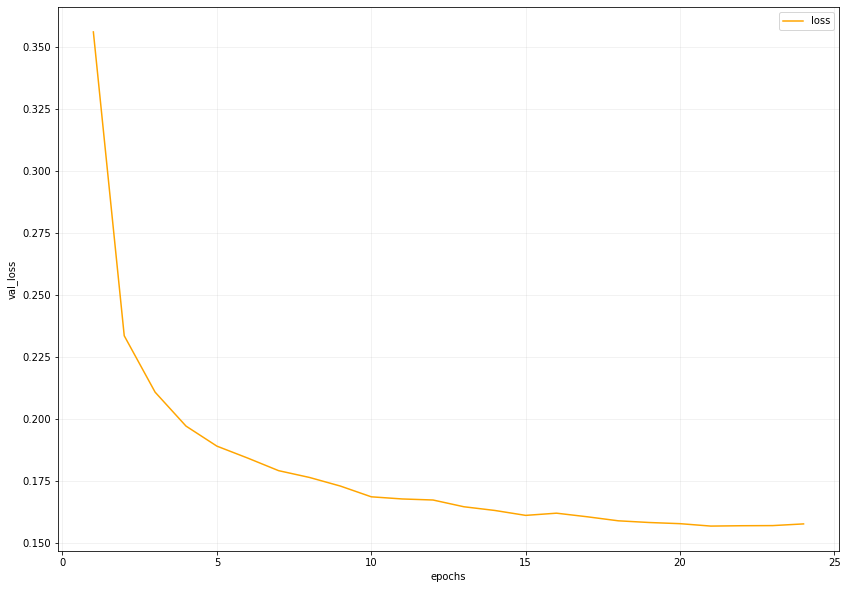

In [190]:
val_loss = classifier.history['loss']
xc = range(1, len(classifier.history['loss'])+1)

plt.figure(figsize=(14,10))
plt.plot(xc, val_loss, label='loss', c='orange')
plt.xlabel('epochs')
plt.ylabel('val_loss')
plt.grid(alpha=0.2)
plt.legend()
plt.show()

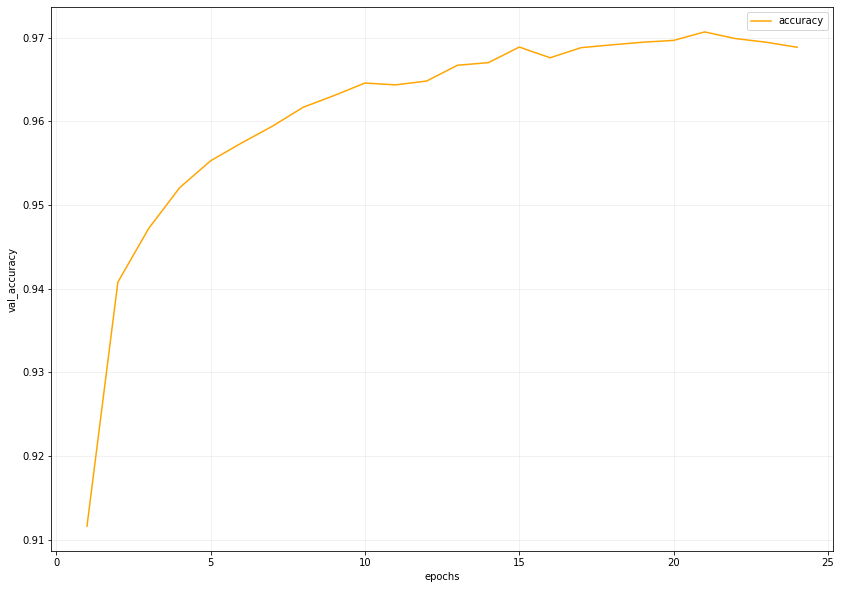

In [191]:
val_accuracy = classifier.history['accuracy']
xc = range(1, len(classifier.history['loss'])+1)

plt.figure(figsize=(14,10))
plt.plot(xc, val_accuracy, label='accuracy', c='orange')
plt.xlabel('epochs')
plt.ylabel('val_accuracy')
plt.grid(alpha=0.2)
plt.legend()
plt.show()

In [167]:
model.save_weights('./weights/my_model')
#model.load_weights('./weights/my_model')

In [11]:
data.corr()

,chroma_stft,chroma_cqt,chroma_cens,melspectrogram,rmse,spectral_centroid,spectral_bandwidth,spectral_contrast,spectral_flatness,rolloff,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
chroma_stft,1.000000,0.718136,0.591841,-0.458686,-0.484914,0.147163,0.322583,-0.442546,-0.341925,0.227077,...,0.239643,0.318593,-0.068207,0.360240,0.244814,0.179921,0.103227,0.405300,0.028861,0.123432
chroma_cqt,0.718136,1.000000,0.897708,-0.398207,-0.479606,0.158176,0.242029,-0.643054,-0.202775,0.191008,...,0.109182,0.160163,0.004510,0.245711,0.133124,0.196914,0.095999,0.251383,0.119106,-0.063013
chroma_cens,0.591841,0.897708,1.000000,-0.370689,-0.436089,0.180550,0.178758,-0.551669,-0.156172,0.187509,...,0.097089,0.107856,0.044616,0.251314,0.124589,0.220031,0.121258,0.263810,0.157839,-0.012569
melspectrogram,-0.458686,-0.398207,-0.370689,1.000000,0.953072,-0.229549,-0.355486,0.032946,0.582523,-0.294255,...,-0.220916,-0.090685,-0.041054,-0.264857,-0.117676,-0.247906,-0.124174,-0.289665,-0.098397,-0.256358
rmse,-0.484914,-0.479606,-0.436089,0.953072,1.000000,-0.178741,-0.347162,0.121213,0.542353,-0.247429,...,-0.226395,-0.104187,-0.093234,-0.269240,-0.141688,-0.275869,-0.140460,-0.285476,-0.149619,-0.315971
spectral_centroid,0.147163,0.158176,0.180550,-0.229549,-0.178741,1.000000,0.631720,0.182427,-0.132828,0.927251,...,-0.040932,-0.037445,-0.220995,0.180172,-0.293438,0.169999,-0.176105,0.124121,-0.161687,-0.081660
spectral_bandwidth,0.322583,0.242029,0.178758,-0.355486,-0.347162,0.631720,1.000000,0.054815,-0.290944,0.836642,...,0.020011,0.094210,-0.220801,0.274110,-0.277463,0.262700,-0.208020,0.156373,-0.060078,0.133428
spectral_contrast,-0.442546,-0.643054,-0.551669,0.032946,0.121213,0.182427,0.054815,1.000000,-0.157495,0.155963,...,0.001398,-0.027100,-0.103703,0.045466,-0.123341,-0.006434,-0.105491,0.049310,-0.175405,0.121932
spectral_flatness,-0.341925,-0.202775,-0.156172,0.582523,0.542353,-0.132828,-0.290944,-0.157495,1.000000,-0.191323,...,-0.138720,0.016910,-0.055887,-0.113501,-0.061273,-0.120319,-0.047242,-0.148366,-0.042329,-0.199859
rolloff,0.227077,0.191008,0.187509,-0.294255,-0.247429,0.927251,0.836642,0.155963,-0.191323,1.000000,...,-0.007982,0.002516,-0.225062,0.227524,-0.285881,0.206756,-0.200066,0.165328,-0.137323,0.006001


In [18]:
model.predict_classes(X_test[0:1])

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


array([[1]], dtype=int32)

In [196]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_66 (Dense)             (None, 256)               4864      
_________________________________________________________________
dense_67 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_68 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_69 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_70 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_71 (Dense)             (None, 1)                 17        
Total params: 48,641
Trainable params: 48,641
Non-trainable params: 0
_________________________________________________

In [210]:
# Тестовые данные. Предсказание
data1 = pd.read_csv('test-dataset.csv')
data1 = data1.drop(['spectral_centroid', 'rolloff', 'mfcc2', 'mfcc4', 'mfcc13', 'mfcc3', 'mfcc5', 'mfcc8'],axis=1)
data1.head()
scaler = StandardScaler()
XTest = scaler.fit_transform(np.array(data1.iloc[:, 1:-1], dtype = float))

In [201]:
print(len(data1))
#print(len(list(filter(lambda x: 'human' in x, data2['filename']))))
data1 = data1[(np.abs(stats.zscore(data1.iloc[:, 1:-1])) < 3).all(axis=1)]
print(len(data1))

5000
4521


In [169]:
with open("output.txt", 'w') as f:
    for filename, probability in zip(data['filename'], model.predict(XTest)):
        f.write(f'{filename}, {probability[0]}\n')

In [212]:
model.predict(XTest[19, np.newaxis])

array([[0.9787632]], dtype=float32)

In [77]:
model.predict_classes(X[1:2])

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


array([[0]], dtype=int32)